In [1]:
%matplotlib widget

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import proj3d

from rosbag import Bag

import os
try: data_dir = data_dir = os.path.realpath(os.path.join(os.path.dirname(__file__), '../data'))
except NameError: data_dir = os.path.realpath(os.path.join(globals()['_dh'][0], '../data'))

In [2]:
traject_filename = os.path.join(data_dir, 'trajectory_with_imu.txt')
print(f'reading trajectory from:\n\t{traject_filename}')

trajectory = []
start_time = None
timestamp = 0

with open(traject_filename) as f:    
    x, y, z = [], [], []
    in_points = False
    in_stamp = False
    for line in f:
        if 'stamp' in line:
            in_stamp = True
        elif 'frame_id' in line:
            in_stamp = False
        if in_stamp:
            if 'nsecs' in line:
                nsec = float(line.split(':')[-1])
                timestamp += nsec * 1e-9
                if not start_time:
                    start_time = timestamp
            elif 'secs' in line:
                timestamp = float(line.split(':')[-1])

        # find the start of the section that contains all point
        if 'points' in line:
            in_points = True
            # reset
            x, y, z = [], [], []
        elif 'color' in line:
            in_points = False
        
        if in_points:
            # get the x and y values
            if 'x' in line:
                x.append(float(line.split(':')[-1]))
            if 'y' in line:
                y.append(float(line.split(':')[-1]))
            if 'z' in line:
                z.append(float(line.split(':')[-1]))

times = np.linspace(start_time, timestamp, len(x))
trajectory = pd.DataFrame(zip(times, x, y, z), columns=['timestamp', 'x', 'y', 'z'])

trajectory['timestamp'] = pd.to_datetime(trajectory['timestamp']*1e9, unit='ns')
trajectory = trajectory.set_index('timestamp')

trajectory

reading trajectory from:
	D:\60 MSc Robotics\Perception Cognition Navigation\Assignments\RPCN\data\trajectory_with_imu.txt


,x,y,z
timestamp,,,
2022-11-30 10:20:54.066980864,0.000000,0.000000,0.0
2022-11-30 10:20:54.101771776,-0.000323,-0.000089,0.0
2022-11-30 10:20:54.136562944,0.003223,0.000491,0.0
2022-11-30 10:20:54.171354112,0.008340,0.002151,0.0
2022-11-30 10:20:54.206145280,0.002694,0.001345,0.0
...,...,...,...
2022-11-30 10:22:55.661821696,0.266141,0.287691,0.0
2022-11-30 10:22:55.696612864,0.266350,0.281892,0.0
2022-11-30 10:22:55.731403776,0.268150,0.275392,0.0


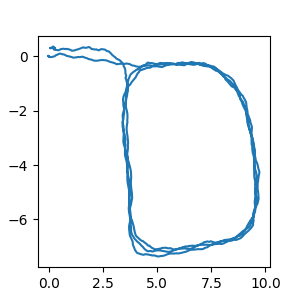

In [3]:
plt.figure(figsize=(3, 3))
plt.plot(trajectory['x'], trajectory['y'])
plt.show()

In [4]:
bag_filename = os.path.join(data_dir, 'test3.bag')
print(f'reading lidar scan data from:\n\t{bag_filename}')

def get_xy(msg):
    x = np.zeros(shape=[len(msg.ranges)])
    y = np.zeros(shape=[len(msg.ranges)])
    for nr, dist in enumerate(msg.ranges):
        # Lidar returns angle and distance. translate to xy positions
        angle = msg.angle_min + msg.angle_increment * nr
        x[nr] = dist * np.cos(angle)
        y[nr] = dist * np.sin(angle)
    return x, y

scan0 = []
scan1 = []
for topic, msg, t in Bag(bag_filename):
    if topic == '/scan0':
        x, y = get_xy(msg)
        scan0.append( (-x, y) )         # flip x axis for scan0
    elif topic == '/scan1':
        x, y = get_xy(msg)
        scan1.append( (x, y) )

print(f'Lidar0 has {len(scan0)} scans, each with {len(scan0[0][0])} (x,y) coordinates')
print(f'Lidar1 has {len(scan1)} scans, each with {len(scan1[0][0])} (x,y) coordinates')

reading lidar scan data from:
	D:\60 MSc Robotics\Perception Cognition Navigation\Assignments\RPCN\data\test3.bag
Lidar0 has 4001 scans, each with 1081 (x,y) coordinates
Lidar1 has 4108 scans, each with 1081 (x,y) coordinates


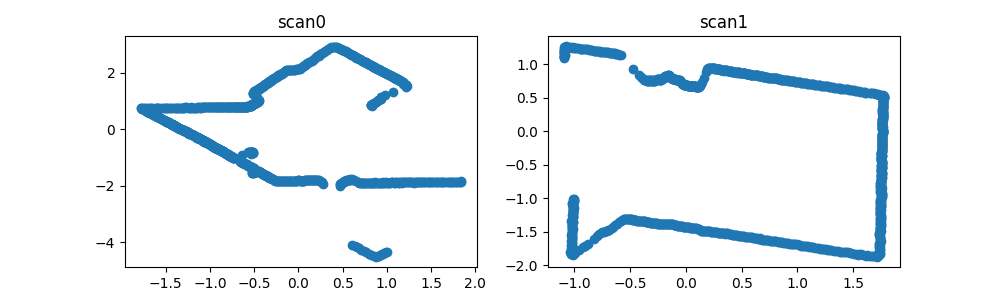

In [5]:
plt.figure(figsize=(10,3))
plt.subplot(1,2,1)
plt.scatter(scan0[-1][0], scan0[-1][1])
plt.title('scan0')
plt.subplot(1,2,2)
plt.scatter(scan1[-1][0], scan1[-1][1])
plt.title('scan1')
plt.show()

In [6]:
print('rotating and translating the scan data to the body frame')

# homogeneous transformations from lidar to body frame
scan0_to_body = np.array([
    [-0.17536324, -0.88242307, -0.43655155,        -0.31542722],
    [ 0.56780261,  0.27159240, -0.77706999,        -0.14370224],
    [ 0.80426857, -0.38414462,  0.45341480,        -0.20138267],
    [ 0.0,         0.0,         0.0,                1.0       ]])

scan1_to_body = np.array([
    [ 0.03916269,  0.87931668,  0.47462455,         0.31813329],
    [-0.53352080,  0.42001741, -0.73412596,        -0.14264865],
    [-0.84487978, -0.22447172,  0.48558275,        -0.19282741],
    [ 0.0,         0.0,         0.0,                1.0       ]])

def homogeneous_inverse(transf):
    # inverse of a homogeneous transformation is the transpose of the rotation
    # and the negative of the translation
    rot = transf[0:3, 0:3].T
    trans = -np.dot(rot, transf[0:3, 3])
    
    inv = np.identity(4)
    inv[0:3, 0:3] = rot
    inv[0:3, 3]   = trans

    return inv

scan0_to_body = homogeneous_inverse(scan0_to_body)
scan1_to_body = homogeneous_inverse(scan1_to_body)

scan0_rot = []
# apply transformation and translation to each scan
for x, y in scan0:
    # make array of homogeneous coordinates. Z is also 0
    transf_points = np.zeros(shape=[4, len(x)])
    transf_points[0, :] = x
    transf_points[1, :] = y
    transf_points[3, :] = 1

    # apply homogenous transformation on points
    transf_points = np.dot(scan0_to_body, transf_points)

    # remove 4th value and transpose
    transf_points = transf_points[0:3, :].T
    scan0_rot.append(transf_points)


scan1_rot = []
# apply transformation and translation to each scan
for x, y in scan1:
    # make array of homogeneous coordinates. Z is also 0
    transf_points = np.zeros(shape=[4, len(x)])
    transf_points[0, :] = x
    transf_points[1, :] = y
    transf_points[3, :] = 1

    # apply homogenous transformation on points
    transf_points = np.dot(scan1_to_body, transf_points)

    # remove 4th value and transpose
    transf_points = transf_points[0:3, :].T
    scan1_rot.append(transf_points)


rotating and translating the scan data to the body frame


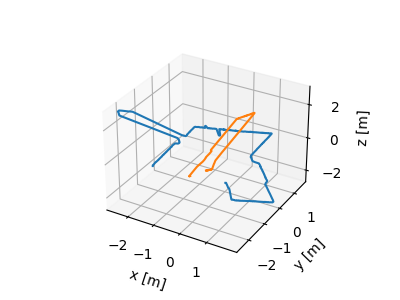

In [7]:
fig = plt.figure(figsize=(4, 3))
ax = plt.axes(projection='3d')
ax.plot(scan0_rot[-1][:, 0], scan0_rot[-1][:, 1], scan0_rot[-1][:, 2], label='scan0')
ax.plot(scan1_rot[-1][:, 0], scan1_rot[-1][:, 1], scan1_rot[-1][:, 2], label='scan1')
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
ax.set_zlabel('z [m]')
plt.show()

In [8]:
from scipy.spatial.transform import Rotation

print("combining scan data and trajectory into a 3d pointcloud")

def rotateScan(scan, trajectory):
    # resample the trajectory so that each position corresponds to scan
    traject_duration = trajectory.index[-1] - trajectory.index[0]
    scan_period = traject_duration / len(scan)
    print(f'trajectory has {len(trajectory)} point. there are {len(scan)} scans')
    print(f"\tresampling {traject_duration} trajectory with sampling period of {scan_period}")

    traject = trajectory.resample(scan_period).mean().interpolate(method='linear')
    traject_vals = traject[['x', 'y', 'z']].values

    total_transform = np.identity(4)
    scan_on_traject = []
    rotations_list= []
    for nr in range(1, len(scan)):
        last_pos = traject_vals[nr-1]
        cur_pos = traject_vals[nr]
        next_pos = traject_vals[nr+1]
        
        # get direction vectors
        last_vector = cur_pos - last_pos
        cur_vector = next_pos - cur_pos
        rotations_list.append(cur_vector)

        # get rotation matrix to go from previous vector to current vector
        cross = np.cross(last_vector, cur_vector)
        dot = np.dot(last_vector, cur_vector)
        cur_rotation = Rotation.from_quat([cross[0], cross[1], cross[2], dot+1]).as_matrix()
        
        # get homogenous transformation matrix
        cur_transform = np.identity(4)
        cur_transform[:3, :3] = cur_rotation
        cur_transform[:3, 3] = cur_vector

        # update total transformation
        total_transform = np.dot(total_transform, cur_transform)

        # apply transformation on homogeneous coordinates
        transf_points = np.zeros(shape=[4, len(x)])
        transf_points[0:3, :] = scan[nr].T
        transf_points[3, :] = 1

        transf_points = np.dot(total_transform, transf_points)
        scan_on_traject.append(transf_points[0:3, :].T)

    return scan_on_traject, rotations_list

scan0_on_trajectory, rotations0 = rotateScan(scan0_rot, trajectory)
scan1_on_trajectory, rotations1 = rotateScan(scan1_rot, trajectory)

combining scan data and trajectory into a 3d pointcloud
trajectory has 3500 point. there are 4001 scans
	resampling 0 days 00:02:01.734005248 trajectory with sampling period of 0 days 00:00:00.030425894
trajectory has 3500 point. there are 4108 scans
	resampling 0 days 00:02:01.734005248 trajectory with sampling period of 0 days 00:00:00.029633399


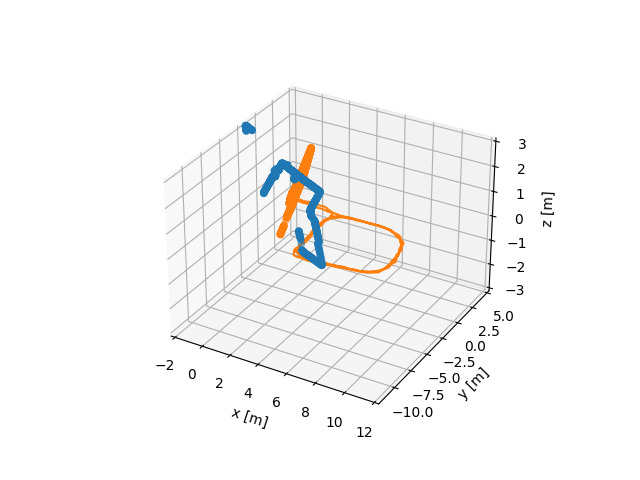

In [15]:
from matplotlib.animation import FuncAnimation

# Create the figure and axes
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.set_xlim([-2, 12])
ax.set_ylim([-12, 5])
ax.set_zlim([-3, 3])

# Initialize the data points to be plotted
datapoint = -1
scan0_line, = ax.plot(scan0_on_trajectory[datapoint][:, 0], scan0_on_trajectory[datapoint][:, 1], scan0_on_trajectory[datapoint][:, 2], label='scan0')
scan1_line, = ax.plot(scan1_on_trajectory[datapoint][:, 0], scan1_on_trajectory[datapoint][:, 1], scan1_on_trajectory[datapoint][:, 2], label='scan0')
rot_vector0, = ax.plot(*zip([0,0,0], 100*rotations0[datapoint]), label='direction0')

ax.plot(trajectory['x'], trajectory['y'])

# Set the axis labels
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
ax.set_zlabel('z [m]')

# Define the function to be called for each animation frame
def update(frame):
    global datapoint
    if(datapoint < -4000):
        datapoint = -1
    datapoint -= 1
    scan0_line.set_data(scan0_on_trajectory[datapoint][:, 0], scan0_on_trajectory[datapoint][:, 1])
    scan0_line.set_3d_properties(scan0_on_trajectory[datapoint][:, 2])
    scan1_line.set_data(scan1_on_trajectory[datapoint][:, 0], scan1_on_trajectory[datapoint][:, 1])
    scan1_line.set_3d_properties(scan1_on_trajectory[datapoint][:, 2])
    rot_vector0.set_data([0, -50*rotations0[datapoint][0]], [0, -50*rotations0[datapoint][1]])
    rot_vector0.set_3d_properties([0, -50*rotations0[datapoint][2]])

# Create the animation object
ani = FuncAnimation(fig, update, frames=range(len(scan0_on_trajectory)), interval=30, blit=True)

running = True

def on_key(event):
    global running
    print(event)
    if event.key == 'p':
        if(running):
            running = False
            print("Pausing")
            ani.event_source.stop()
        else:
            running = True
            print("Resuming")
            ani.event_source.start()
    if event.key == 'q':
        print("Quitting")
        plt.close()

fig.canvas.mpl_connect('key_press_event', on_key)
# Show the animation
plt.show()

In [10]:
pointcloud0 = np.concatenate(scan0_on_trajectory, axis=0)
pointcloud1 = np.concatenate(scan1_on_trajectory, axis=0)

pointcloud = np.concatenate([pointcloud0, pointcloud1], axis=0)

pointcloud.shape

(8763667, 3)

In [11]:
from pyntcloud import PyntCloud

pynt_pointcloud = PyntCloud(pd.DataFrame(pointcloud[::300, :], columns=['x', 'y', 'z']))
pynt_pointcloud.points.describe()

,x,y,z
count,29213.000000,29213.000000,29213.000000
mean,5.708103,-3.245455,0.238732
std,2.926237,3.007554,1.099106
min,-3.803128,-17.982799,-7.888328
25%,3.577798,-5.919780,-0.551615
50%,5.388883,-3.083761,0.385425
75%,8.463984,-0.522557,0.958970
max,19.150603,6.259104,9.541244


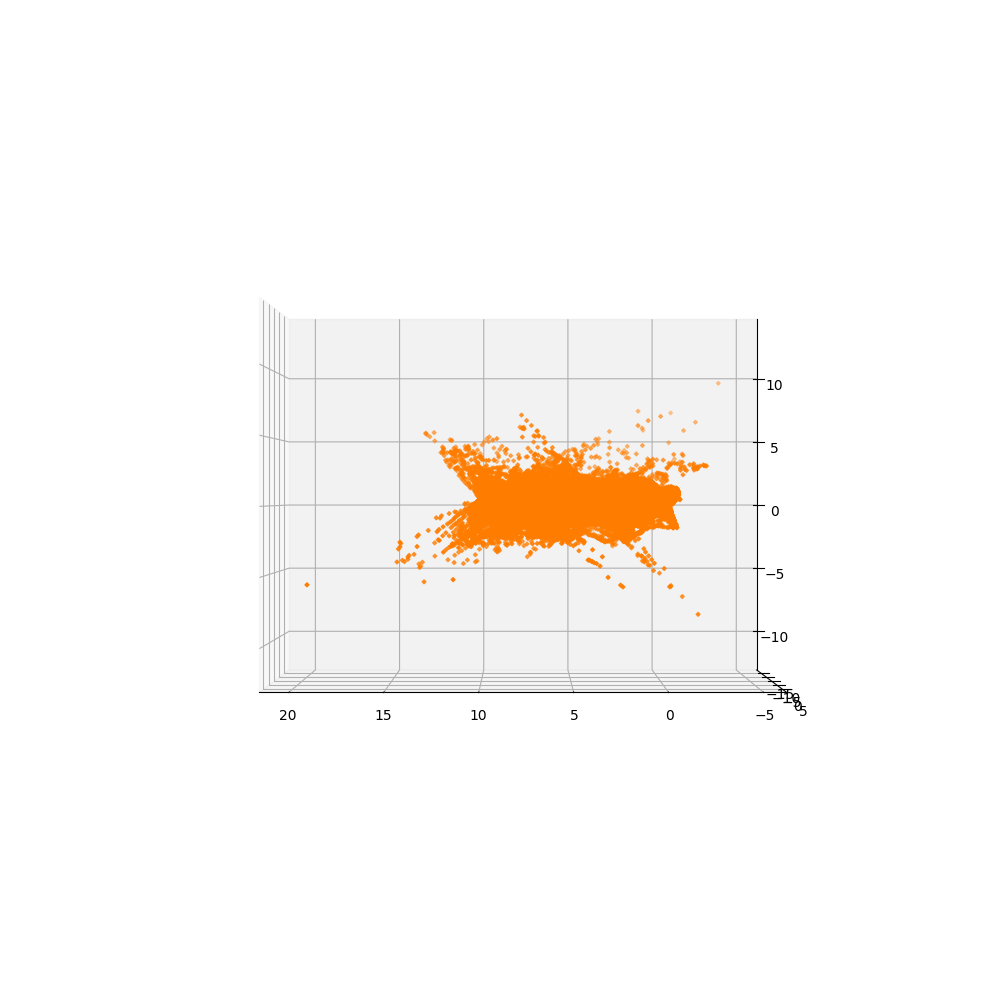

In [12]:
pynt_pointcloud.plot()

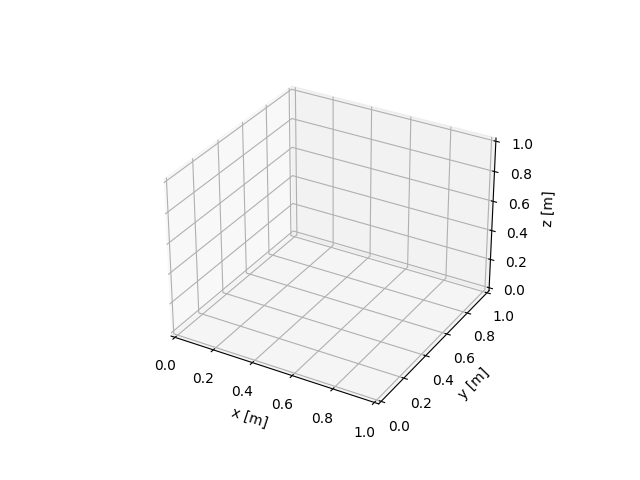

In [13]:
fig = plt.figure()
ax = plt.axes(projection='3d')
# ax.scatter(*pointcloud0, label='scan0')
# ax.scatter(*pointcloud1, label='scan1')
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
ax.set_zlabel('z [m]')
plt.show()